### Retinex model based stain normalization technique for whole slide image analysis 논문 기반에서 조금 보완 진행해봄
* illumination map의 gradient에서 절대값 제거
* 조정 된 illumination map에 minmax normalization 진행

In [1]:
import os
import yaml
from pathlib import Path
from PIL import Image
from scipy import linalg
from scipy.ndimage import gaussian_filter

import numpy as np
import skimage
import matplotlib.pyplot as plt
from openslide import OpenSlide

from src.utils import *
from src.transformer import *
from src.wsi_reader import WSIReader

In [2]:
config = load_config()
config

{'dataset_path': '/Users/cmkim/workspace/datasets/TIGER/'}

In [3]:
image = WSIReader(
    path=Path(config["dataset_path"]) / "wsibulk/images" / "119S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "103S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "144S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "111S.tif"
).read_array(
    level=32
)

In [4]:
od_transformer = OpticalDensityClipTransformer(norm=True)
od = od_transformer.transform(image)

In [5]:
stain_vector = StainSpecficVector.hed()
stain_vector

array([[0.65 , 0.704, 0.286],
       [0.072, 0.99 , 0.105],
       [0.268, 0.57 , 0.776]])

In [6]:
stains = ColorDeconvolution().separate(od, stain_vector)
stains

array([[[ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        ...,
        [ 0.00763391, -0.0015198 ,  0.00742319],
        [ 0.00881215, -0.0021573 ,  0.00707521],
        [ 0.00881215, -0.0021573 ,  0.00707521]],

       [[ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        ...,
        [ 0.00763391, -0.0015198 ,  0.00742319],
        [ 0.00881215, -0.0021573 ,  0.00707521],
        [ 0.00881215, -0.0021573 ,  0.00707521]],

       [[ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        [ 0.00798515, -0.00085486,  0.00639266],
        ...,
        [ 0.00763391, -0.0015198 ,  0.00742319],
        [ 0.00881215, -0.0021573 ,  0.00707521],
        [ 0.00881215, -0.0021573 ,  0.00707521]],

       ...,

       [[ 0.00688698, -0.00130171,  0.00685787],
        [ 0

### illumination map

In [7]:
tmap = np.max(stains, axis=2)
tmap

array([[0.00798515, 0.00798515, 0.00798515, ..., 0.00763391, 0.00881215,
        0.00881215],
       [0.00798515, 0.00798515, 0.00798515, ..., 0.00763391, 0.00881215,
        0.00881215],
       [0.00798515, 0.00798515, 0.00798515, ..., 0.00763391, 0.00881215,
        0.00881215],
       ...,
       [0.00688698, 0.00688698, 0.00688698, ..., 0.00763391, 0.00881215,
        0.00881215],
       [0.00919314, 0.00919314, 0.00919314, ..., 0.00876638, 0.00996012,
        0.00996012],
       [0.0084328 , 0.0084328 , 0.0084328 , ..., 0.00763391, 0.00881215,
        0.00881215]], shape=(1356, 1736))

In [8]:
tmap_gradh = np.gradient(tmap, axis=1)
tmap_gradv = np.gradient(tmap, axis=0)

In [9]:
epsilon = 1e-4
sigma = 6

In [10]:
gaussian = gaussian_filter(tmap, sigma=sigma)
gaussian

array([[0.00799476, 0.00799624, 0.00799922, ..., 0.00791716, 0.00793277,
        0.0079409 ],
       [0.00799396, 0.00799541, 0.00799834, ..., 0.00791716, 0.00793277,
        0.0079409 ],
       [0.0079923 , 0.0079937 , 0.00799653, ..., 0.00791716, 0.00793277,
        0.0079409 ],
       ...,
       [0.00799526, 0.00799331, 0.00798948, ..., 0.00819299, 0.00820217,
        0.00820703],
       [0.00800671, 0.00800481, 0.00800106, ..., 0.00820652, 0.0082153 ,
        0.00821995],
       [0.0080126 , 0.00801072, 0.00800703, ..., 0.00821355, 0.00822213,
        0.00822667]], shape=(1356, 1736))

In [11]:
wh = np.sum(gaussian / (gaussian * tmap_gradh + epsilon), axis=1, keepdims=True)
wv = np.sum(gaussian / (gaussian * tmap_gradv + epsilon), axis=0, keepdims=True)

In [12]:
tmap_adj = tmap / (wh + wv + epsilon)
tmap_adj

array([[-3.37986625e-09, -3.92342415e-09, -3.81080310e-09, ...,
        -3.58291896e-09, -4.13600392e-09, -4.13600000e-09],
       [ 6.49843861e-08,  1.77372247e-08,  2.04724512e-08, ...,
         2.15159847e-08,  2.48335598e-08,  2.48337013e-08],
       [ 2.91625101e-07,  2.25127091e-08,  2.71099118e-08, ...,
         2.94398438e-08,  3.39775730e-08,  3.39778379e-08],
       ...,
       [ 2.51090589e-07,  1.94140477e-08,  2.33778606e-08, ...,
         2.94345435e-08,  3.39714568e-08,  3.39717216e-08],
       [ 3.32911803e-07,  2.59014063e-08,  3.11864207e-08, ...,
         3.37768409e-08,  3.83694499e-08,  3.83697488e-08],
       [ 2.94570871e-07,  2.36915701e-08,  2.85091249e-08, ...,
         2.92990738e-08,  3.38151342e-08,  3.38153966e-08]],
      shape=(1356, 1736))

In [13]:
tmap_adj = (tmap_adj - np.min(tmap_adj)) / (np.max(tmap_adj) - np.min(tmap_adj))
tmap_adj

array([[0.84249608, 0.84249608, 0.84249608, ..., 0.84249608, 0.84249608,
        0.84249608],
       [0.84249647, 0.8424962 , 0.84249622, ..., 0.84249622, 0.84249624,
        0.84249624],
       [0.84249778, 0.84249623, 0.84249626, ..., 0.84249627, 0.8424963 ,
        0.8424963 ],
       ...,
       [0.84249755, 0.84249621, 0.84249624, ..., 0.84249627, 0.8424963 ,
        0.8424963 ],
       [0.84249802, 0.84249625, 0.84249628, ..., 0.8424963 , 0.84249632,
        0.84249632],
       [0.8424978 , 0.84249624, 0.84249627, ..., 0.84249627, 0.8424963 ,
        0.8424963 ]], shape=(1356, 1736))

In [14]:
stains_adj = stains * tmap_adj[..., np.newaxis]
stains_adj

array([[[ 0.00672746, -0.00072022,  0.00538579],
        [ 0.00672746, -0.00072022,  0.00538579],
        [ 0.00672746, -0.00072022,  0.00538579],
        ...,
        [ 0.00643154, -0.00128043,  0.00625401],
        [ 0.0074242 , -0.00181752,  0.00596083],
        [ 0.0074242 , -0.00181752,  0.00596083]],

       [[ 0.00672746, -0.00072022,  0.0053858 ],
        [ 0.00672746, -0.00072022,  0.00538579],
        [ 0.00672746, -0.00072022,  0.00538579],
        ...,
        [ 0.00643154, -0.00128043,  0.00625401],
        [ 0.0074242 , -0.00181752,  0.00596083],
        [ 0.0074242 , -0.00181752,  0.00596083]],

       [[ 0.00672747, -0.00072022,  0.0053858 ],
        [ 0.00672746, -0.00072022,  0.0053858 ],
        [ 0.00672746, -0.00072022,  0.0053858 ],
        ...,
        [ 0.00643154, -0.00128043,  0.00625401],
        [ 0.0074242 , -0.00181752,  0.00596083],
        [ 0.0074242 , -0.00181752,  0.00596083]],

       ...,

       [[ 0.00580226, -0.00109669,  0.00577774],
        [ 0

In [15]:
stains_adj = stains_adj + stains_adj * (1-tmap_adj[..., np.newaxis])
stains_adj

array([[[ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        ...,
        [ 0.00744453, -0.0014821 ,  0.00723904],
        [ 0.00859354, -0.00210378,  0.00689969],
        [ 0.00859354, -0.00210378,  0.00689969]],

       [[ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        ...,
        [ 0.00744453, -0.0014821 ,  0.00723904],
        [ 0.00859354, -0.00210378,  0.00689969],
        [ 0.00859354, -0.00210378,  0.00689969]],

       [[ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        [ 0.00778706, -0.00083365,  0.00623408],
        ...,
        [ 0.00744453, -0.0014821 ,  0.00723904],
        [ 0.00859354, -0.00210378,  0.00689969],
        [ 0.00859354, -0.00210378,  0.00689969]],

       ...,

       [[ 0.00671613, -0.00126942,  0.00668774],
        [ 0

In [16]:
null = np.zeros_like(stains[:, :, 0])

In [17]:
hematoxylin = skimage.color.hed2rgb(np.stack((stains[:, :, 0], null, null), axis=-1))
eosin = skimage.color.hed2rgb(np.stack((null, stains[:, :, 1], null), axis=-1))
dab = skimage.color.hed2rgb(np.stack((null, null, stains[:, :, 2]), axis=-1))

In [18]:
hematoxylin_adj = skimage.color.hed2rgb(np.stack((stains_adj[:, :, 0], null, null), axis=-1))
eosin_adj = skimage.color.hed2rgb(np.stack((null, stains_adj[:, :, 1], null), axis=-1))
dab_adj = skimage.color.hed2rgb(np.stack((null, null, stains_adj[:, :, 2]), axis=-1))

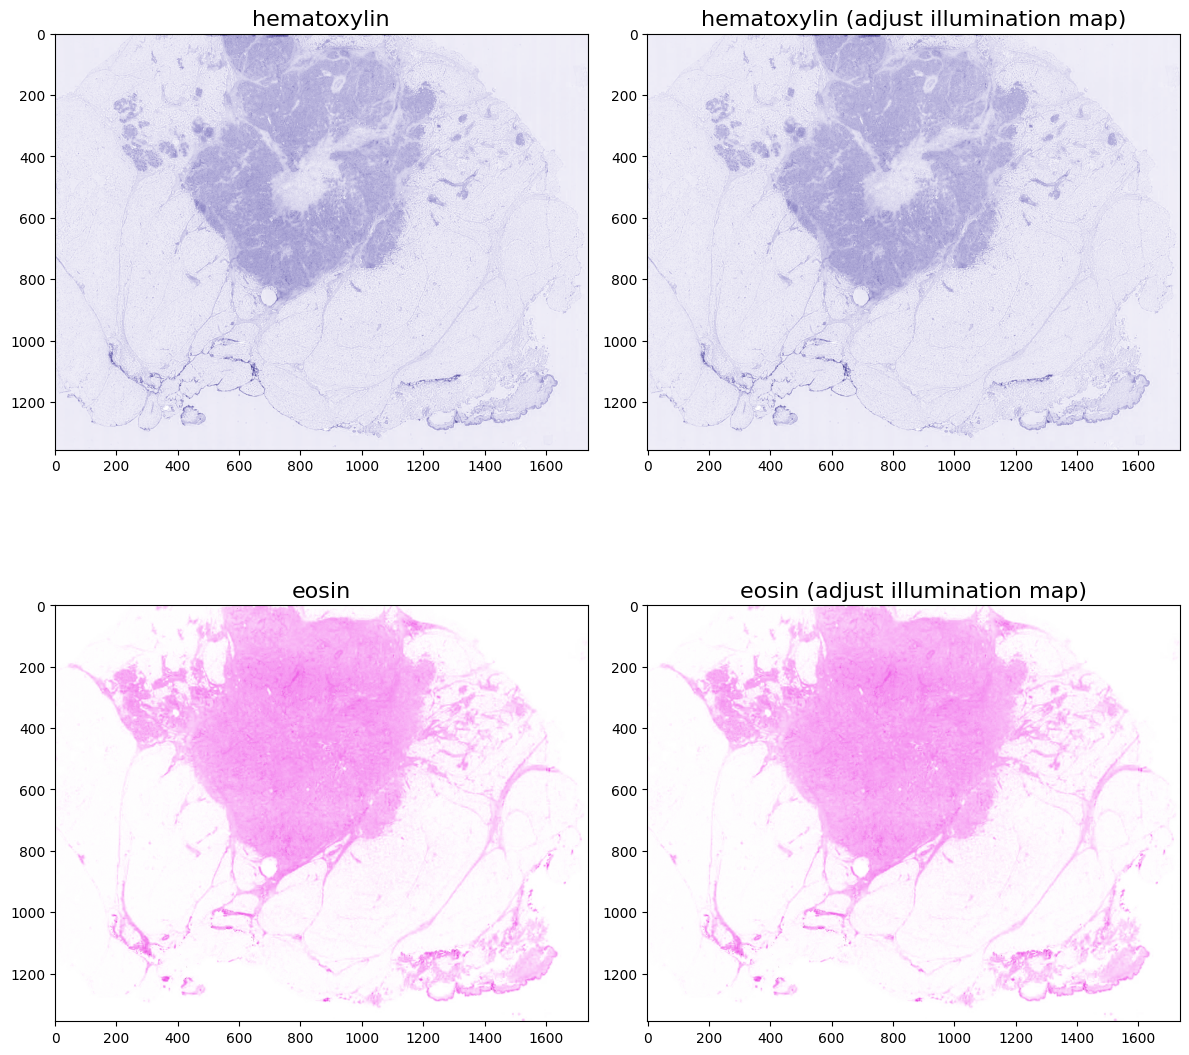

In [19]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
ax.imshow(hematoxylin)
ax.set_title(label="hematoxylin", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(hematoxylin_adj)
ax.set_title(label="hematoxylin (adjust illumination map)", fontdict=fontdict)

ax = fig.add_subplot(223)
ax.imshow(eosin)
ax.set_title(label="eosin", fontdict=fontdict)

ax = fig.add_subplot(224)
ax.imshow(eosin_adj)
ax.set_title(label="eosin (adjust illumination map)", fontdict=fontdict)

fig.tight_layout()
plt.show()

### Recover

In [20]:
image_adj = stain_combine(stains_adj, stain_vector, True, od_transformer.thres)

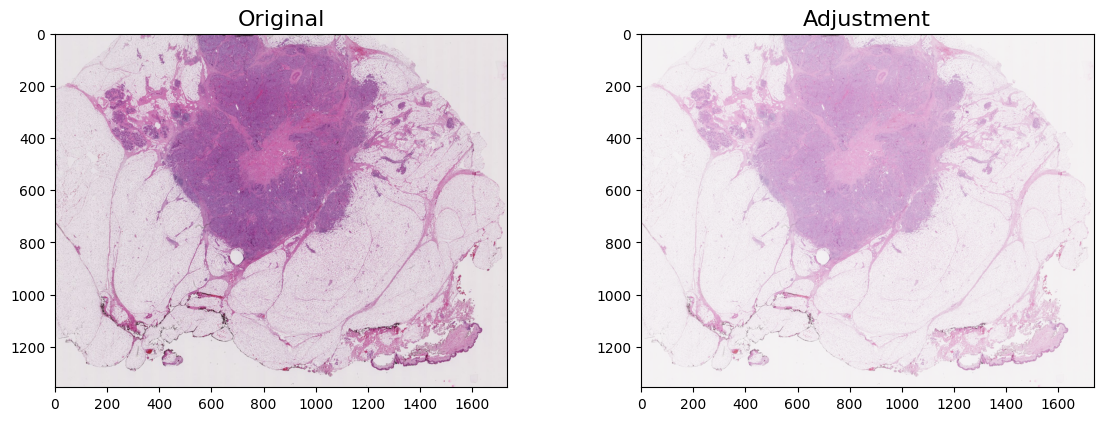

In [21]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(221)
ax.imshow(image)
ax.set_title(label="Original", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(image_adj)
ax.set_title(label="Adjustment", fontdict=fontdict)

fig.tight_layout()
plt.show()